## 3.3 Hypothesis Testing

Repetition of Task 3.2 using a different model for each dataset. We will use hypothesis testing to compare the performance of the models developed in this task and Task 3.2.

In [75]:
import numpy as np
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import ttest_ind, ttest_rel

%load_ext autoreload
%autoreload 2

import bamboo.gwp_pipeline as gwp
import bamboo.star_pipeline as star
from bamboo.processing import read_csv, split_features_and_target, get_feature_and_target_names 
from bamboo.selection import normalize_data
from bamboo.model import Model, get_classification_prediction_data
from bamboo.analysis import *

SEED = 42

GWP_CSV = 'datasets/gwp_assessment.csv'
STAR_CSV = 'datasets/star_assessment.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset Preperation

Repeated steps to initialisze gwp & star datasets to be passed to models just like in task3_2.ipynb

In [63]:
# Load and process GWP from csv
gwp_data = read_csv(GWP_CSV)
gwp_dataset = gwp.gwp_pipeline(gwp_data)

X_gwp, y_gwp = split_features_and_target(gwp_dataset)
X_gwp_names, y_gwp_name = get_feature_and_target_names(gwp_dataset)
X_gwp_train, X_gwp_test, y_gwp_train, y_gwp_test = train_test_split(X_gwp, y_gwp, test_size=0.2, random_state=SEED)
X_gwp_train, X_gwp_test = normalize_data(X_gwp_train, X_gwp_test)

# Load and process Star from csv
star_data = read_csv(STAR_CSV)
star_dataset = star.star_pipeline(star_data)

X_star, y_star = split_features_and_target(star_dataset)
X_star_names, y_star_name = get_feature_and_target_names(star_dataset)
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, y_star, test_size=0.2, random_state=SEED)
X_star_train, X_star_test = normalize_data(X_star_train, X_star_test)

/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/bamboo/processing.py:12: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(csv_file, delimiter=',', dtype=None, names=True)
/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/bamboo/processing.py:12: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(csv_file, delimiter=',', dtype=None, names=True)


## GWP Model implementation & training
Random Forest Regression (RFR) model.

In [ ]:
# Initialize the parammeters
parameters = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 5, 10, 20, 50],
    'max_features': [1, 'sqrt', 'log2'],
}

rfr = RandomForestRegressor(random_state = SEED)

# Instantiate the Model class with SVR model and the parameter grid
gwp_model = Model(model=rfr, params=parameters, search_type='GridSearch')
gwp_model.fit(X_gwp_train, y_gwp_train)

# Save the model
gwp_model.save_model('models/gwp/rfr.pkl')
gwp_model.save_results('results/gwp/rfr.pkl')


## Star Model implementation & training
Random Forest Classification (RFC) model.

<div class="warning">
    <strong>Warning:</strong> Running this model with all parameter configurations may take upwards of an hour to complete. You can load in the saved model and result from the local directories if you would like to use the optimal trained model.
</div>

<style>
.warning {
    background-color: #ffeeba;
    border-color: #ffc107;
    color: #856404;
    padding: 1em;
    margin-top: 1em;
    margin-bottom: 1em;
    border: 1px solid transparent;
    border-radius: 0.25rem;
}
</style>

In [ ]:
# Initialize the parammeters
parameters = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 5, 10, 20, 50],
    'max_features': [1, 'sqrt', 'log2'],
}

rfc = RandomForestClassifier(random_state = SEED)

# Instantiate the Model class with SVR model and the parameter grid
star_model = Model(model=rfc, params=parameters, search_type='HalvingGridSearch')
star_model.fit(X_star_train, y_star_train)

# Save the model
star_model.save_model('models/star/rfc.pkl')
star_model.save_results('results/star/rfc.pkl')

## GWP Model Analysis

Load in the saved gwp model and results.

In [67]:
gwp_model = Model()
gwp_model.load_model('models/gwp/rfr.pkl')
gwp_model.load_results('results/gwp/rfr.pkl')

Show best model results from parameter tuning

In [51]:
gwp_model.get_best_configuration()

{'Best Params': {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 500},
 'Best Score': 0.5,
 'Time Taken': 0.465}

### Average time & score for each parameter tested

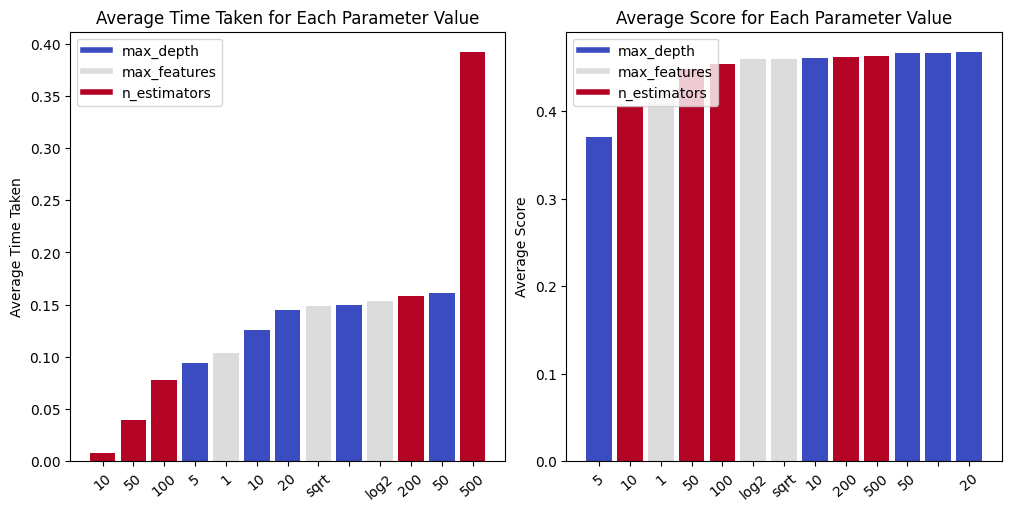

In [45]:
gwp_configurations = gwp_model.get_configurations(sort_by='Score', n_results=250, ascending=False)
plot_bar_avg_metrics(gwp_configurations)

### Predicting on Test set

In [57]:
y_gwp_pred = gwp_model.predict(X_gwp_test)
print_regression_metrics(y_gwp_test, y_gwp_pred)

Score (R-squared): 0.5534439001417935
Mean Absolute Error (MAE): 0.07170856748202041
Root Mean Squared Error (RMSE): 0.10889061434487138


#### Scatter Plot: Predicted vs Actual

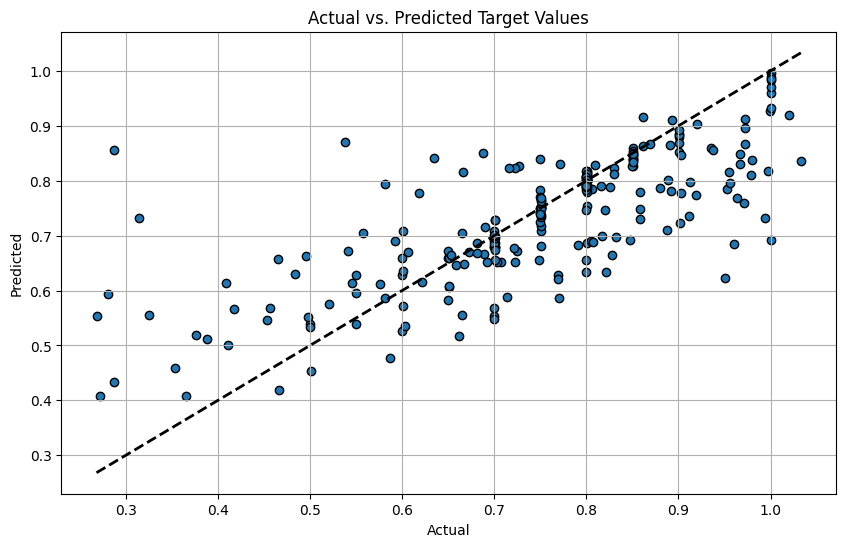

In [60]:
plot_predicted_vs_actual(y_gwp_test, y_gwp_pred)

## Star Model Analysis

Load in the saved star model and results.

In [10]:
star_model = Model()
star_model.load_model('models/star/rfc.pkl')
star_model.load_results('results/star/rfc.pkl')

Show best model results from parameter tuning

In [55]:
star_model.get_best_configuration()

{'Best Params': {'max_depth': None,
  'max_features': 'sqrt',
  'n_estimators': 200},
 'Best Score': 0.98,
 'Time Taken': 31.278}

### Precision Recall, ROC, DET Curves

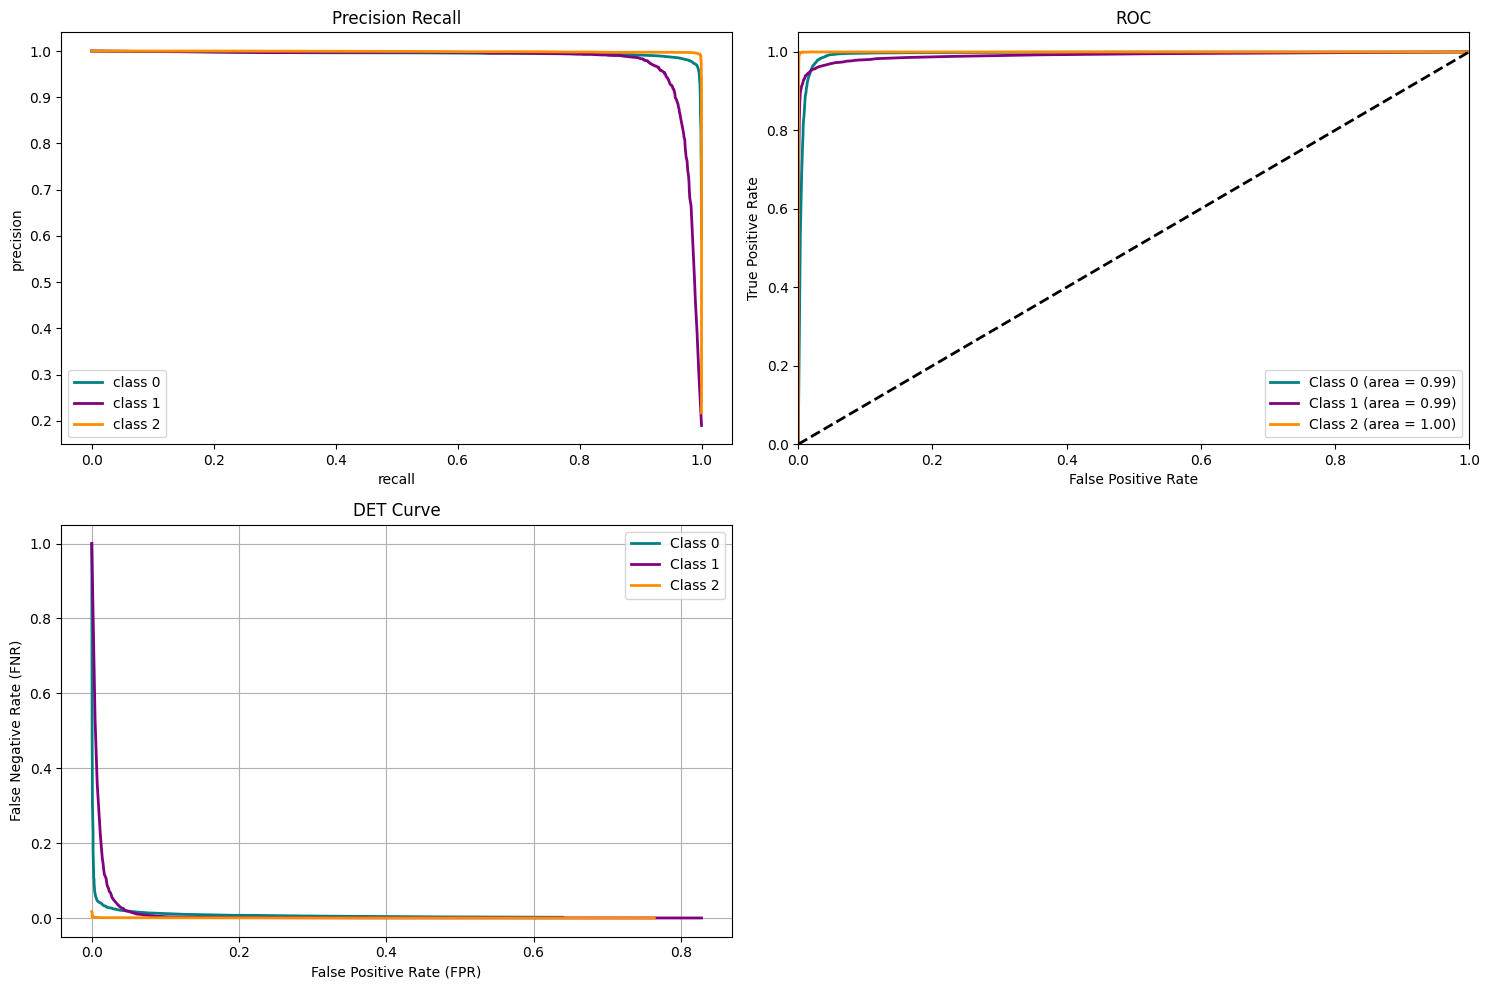

In [40]:
classes = np.unique(y_star_test)
data_per_class = get_classification_prediction_data(star_model.model, X_star_test, y_star_test, classes)

plot_side_by_side(
    lambda: plot_precision_recall_curve(data_per_class, classes), 
    lambda: plot_roc_curve(data_per_class, classes),
    lambda: plot_det_curve(data_per_class, classes),
    titles=['Precision Recall', 'ROC', 'DET Curve'],
    num_cols=2,
    figsize=(15, 10))

### Average time & score for each parameter tested

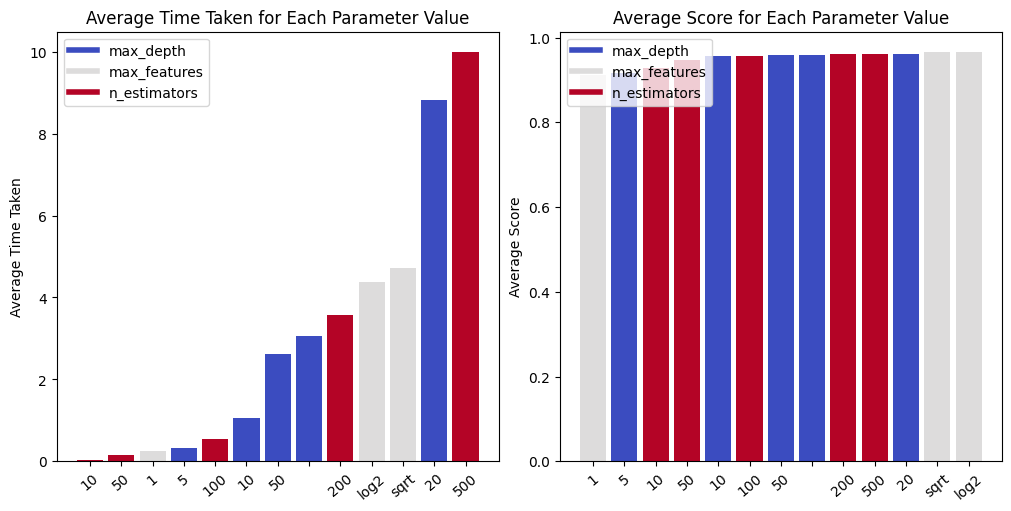

In [46]:
star_configurations = star_model.get_configurations(sort_by='Score', n_results=250, ascending=False)
plot_bar_avg_metrics(star_configurations)

### Predicting on Test set

In [50]:
y_star_pred = star_model.predict(X_star_test)
print("Prediction Score: ", star_model.model.score(X_star_test, y_star_test))

Prediction Score:  0.97675


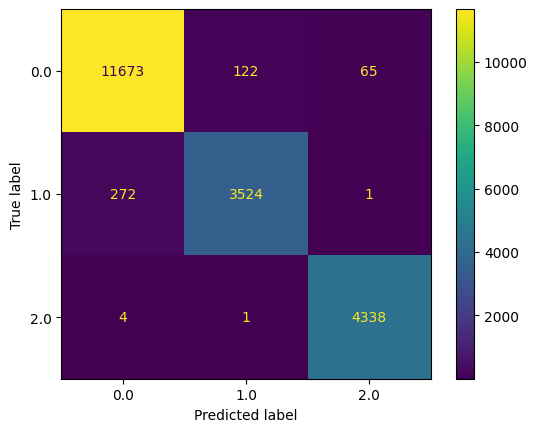

In [49]:
ConfusionMatrixDisplay.from_predictions(y_star_test, y_star_pred)
plt.show()

## GWP Hypothesis Testing 

In [68]:
# Load SVR model
gwp_svr = Model()
gwp_svr.load_model('models/gwp/svr.pkl')
gwp_svr.load_results('results/gwp/svr.pkl')

# Load RFR model
gwp_rfr = Model()
gwp_rfr.load_model('models/gwp/rfr.pkl')
gwp_rfr.load_results('results/gwp/rfr.pkl')

In [ ]:
svr_pred = gwp_svr.predict(X_gwp_test)
rfr_pred = gwp_rfr.predict(X_gwp_test)

svr_mse = mean_squared_error(y_gwp_test, svr_pred)
rfr_mse = mean_squared_error(y_gwp_test, rfr_pred)

print(f'Model 1 MSE: {svr_mse}')
print(f'Model 2 MSE: {rfr_mse}')

# Or you could use cross-validation
svr_scores = cross_val_score(gwp_svr, X_gwp_test, y_gwp_test, cv=5)
rfr_scores = cross_val_score(gwp_rfr, X_gwp_test, y_gwp_test, cv=5)

## Star Hypothesis Testing 

In [65]:
# Load SVC model
star_svc = Model()
star_svc.load_model('models/star/svc.pkl')
star_svc.load_results('results/star/svc.pkl')

# Load RFC model
star_rfc = Model()
star_rfc.load_model('models/star/rfc.pkl')
star_rfc.load_results('results/star/rfc.pkl')

In [73]:
svc_pred = star_svc.predict(X_star_test)
rfc_pred = star_rfc.predict(X_star_test)

# Compute the performance metrics for each model
svc_accuracy = accuracy_score(y_star_test, svc_pred)
rfc_accuracy = accuracy_score(y_star_test, rfc_pred)

t_stat, p_val = ttest_rel([rfc_accuracy], [svc_accuracy])

print("RFC Accuracy: ", rfc_accuracy)
print("SVC Accuracy: ", svc_accuracy)
print("T-Statistic: ", t_stat)


RFC Accuracy:  0.97675
SVC Accuracy:  0.9552
T-Statistic:  nan


/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


#### Markdown Question: 
**Question**: What was the hypothesis you rejected for both datasets in this task? How does p-value affect your decision?